In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import math
import seaborn as sns
import plotly.graph_objects as go


In [2]:
#Reading data
#Spanish data from spanish health ministry, all hisotrical series
data = pd.read_csv(r"https://covid19.isciii.es/resources/serie_historica_acumulados.csv",skipfooter=3,error_bad_lines=False,encoding = 'ANSI')

data.columns = ['CCAA Codigo ISO','Fecha','Casos Old','Casos','TestAc','Hospitalizados','UCI','Fallecidos','Recuperados']
#World data from Johns Hopkins University (github)
#Confirmed cases
data_jh_conf = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Confirmed deaths
data_jh_muertos = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Confirmed recovered
data_jh_recuperados = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Cataluña data
data_cat = pd.read_csv(r"https://analisi.transparenciacatalunya.cat/api/views/jj6z-iyrp/rows.csv?accessType=DOWNLOAD&bom=true&format=true&delimiter=%3B&sorting=true", sep=";",encoding = 'utf-8')

#Spanish data from Madrid
data_madrid = pd.read_csv(r"https://datos.comunidad.madrid/catalogo/dataset/7da43feb-8d4d-47e0-abd5-3d022d29d09e/resource/b2a3a3f9-1f82-42c2-89c7-cbd3ef801412/download/covid19_tia_muni_y_distritos.csv", sep=";",encoding = 'ANSI')

#datos de renta por municipios
data_renta_municipios = pd.read_csv(r"C:\Users\guillermo.arguello\Documents\Covid Analisys\renta_municipios.csv", sep="|",encoding = 'ANSI')

#datos población paises

data_poblacion = pd.read_excel('https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/EXCEL_FILES/1_Population/WPP2019_POP_F01_1_TOTAL_POPULATION_BOTH_SEXES.xlsx',
                                    sheet_name="ESTIMATES",skiprows= 16)

data_poblacion = data_poblacion[["Region, subregion, country or area *","2020"]]

data["Casos"] =  np.where(data["Casos"].isna(), data["Casos Old"],data["Casos"])


In [3]:
#Transpose Johns Hopkins Data

data_jh_conf = data_jh_conf.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Casos')
data_jh_muertos = data_jh_muertos.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Fallecidos')
data_jh_recuperados = data_jh_recuperados.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Recuperados')

#Join all data in one dataframe
data_jh = pd.merge(data_jh_conf, data_jh_muertos, left_on=['Province/State','Country/Region','Fecha','Lat','Long'], 
                   right_on = ['Province/State','Country/Region','Fecha','Lat','Long'])

data_jh = pd.merge(data_jh, data_jh_recuperados, how= 'left',left_on=['Province/State','Country/Region','Fecha','Lat','Long'], 
                   right_on = ['Province/State','Country/Region','Fecha','Lat','Long'])

#Removing Province/State, Lat and long data, we won´t use it (it could be usefull for geographical plots)

data_jh = data_jh.drop(["Province/State","Lat","Long"], axis=1)


In [4]:
data_jh = data_jh.dropna()
data_jh = data_jh.groupby(['Fecha','Country/Region'], as_index=False).sum()
data_jh = data_jh.sort_values(by=['Fecha'])
data_jh["Fecha2"] = pd.to_datetime(data_jh["Fecha"], format="%m/%d/%y").dt.strftime('%Y%m%d').astype(int).sort_values(ascending=False)
data_jh["Fecha"] = pd.to_datetime(data_jh["Fecha"], format="%m/%d/%y")
data_jh["Casos"] = pd.to_numeric(data_jh["Casos"])
data_jh["Fallecidos"] = pd.to_numeric(data_jh["Fallecidos"])
data_jh["Recuperados"] = pd.to_numeric(data_jh["Recuperados"])
data_jh["Country/Region"] = data_jh["Country/Region"].astype(str)

data_jh = data_jh.set_index('Fecha2')
data_jh = data_jh.sort_index()
data_jh = data_jh.reset_index()

data_jh['Diferencia casos dia anterior'] = data_jh.groupby('Country/Region', as_index=True).diff(1)["Casos"]
data_jh['Diferencia fallecidos dia anterior'] = data_jh.groupby('Country/Region', as_index=True).diff(1)["Fallecidos"]
data_jh['Diferencia recuperados dia anterior'] = data_jh.groupby('Country/Region', as_index=True).diff(1)["Recuperados"]
data_jh = data_jh.fillna(0)
data_jh = data_jh.drop(["Fecha2"], axis=1)

data_jh = pd.merge(data_jh, data_poblacion, how= 'left',left_on=['Country/Region'], 
                   right_on = ['Region, subregion, country or area *'])

data_jh = data_jh.set_index('Fecha')
data_jh["Incremento porcentual de casos respecto al total"]= data_jh["Diferencia casos dia anterior"]/data_jh["Casos"]*100
data_jh["Incremento porcentual de fallecidos respecto al total"]= data_jh["Diferencia fallecidos dia anterior"]/data_jh["Fallecidos"]*100

data_jh = data_jh.rename(columns={"2020": "2020 Population"})

data_jh["Fallecidos por millón habitantes"]= data_jh["Fallecidos"]/(data_jh["2020 Population"]/1000)


data_sem_jh = data_jh.groupby(['Country/Region'], as_index=True).rolling(7, center=False).mean()

In [5]:
data = data.fillna(0)
data.drop(data[ data['Fecha'] == 0 ].index , inplace=True)
data["Fecha"] = pd.to_datetime(data["Fecha"], format="%d/%m/%Y").sort_values()
data['Diferencia casos dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=True).diff(1)["Casos"]
data['Diferencia hospitalizados dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=True).diff(1)["Hospitalizados"]
data['Diferencia UCI dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=True).diff(1)["UCI"]
data['Diferencia fallecidos dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=True).diff(1)["Fallecidos"]
data['Diferencia recuperados dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=True).diff(1)["Recuperados"]

data = data.fillna(0)
data_es = data.groupby('Fecha', as_index=False).sum()
data_es = data_es.set_index('Fecha')
data_es = data_es[data_es["Fallecidos"] > 10]
data_es["Incremento porcentual de casos respecto al total"]= (data_es["Diferencia casos dia anterior"]/data_es["Casos"]*100).round(3)
data_es["Incremento porcentual de fallecidos respecto al total"]= (data_es["Diferencia fallecidos dia anterior"]/data_es["Fallecidos"]*100).round(3)

data_sem = data_es.rolling(7, center=False).mean()


In [6]:
data_cat["Data"] = pd.to_datetime(data_cat["TipusCasData"], format="%d/%m/%Y").sort_values()
data_cat_gropued = data_cat.groupby('Data',as_index = False).sum().sort_values('Data',ascending=True)
data_cat_gropued = data_cat_gropued[data_cat_gropued["Data"] > "2020-03-01"]
data_cat_gropued = data_cat_gropued.set_index('Data')
data_cat_gropued_resultado = data_cat.groupby(['Data',"TipusCasDescripcio"],as_index = False).sum().sort_values('Data',ascending=True)
data_cat_gropued_resultado = data_cat_gropued_resultado[data_cat_gropued_resultado["Data"] > "2020-03-01"]
data_cat_gropued_resultado = data_cat_gropued_resultado.set_index('Data')

In [7]:
#Procasamiento datos Madrid
data_madrid = data_madrid[["municipio_distrito","fecha_informe","casos_confirmados_totales","tasa_incidencia_acumulada_total"]]
data_madrid = data_madrid.dropna()
data_madrid["municipio_distrito"]= data_madrid["municipio_distrito"].str.strip()
data_renta_municipios["MUNICIPIO"]= data_renta_municipios["MUNICIPIO"].str.strip()

data_renta_municipios = data_renta_municipios[["MUNICIPIO","RENTA DISPONIBLE MEDIA","NUMERO HABITANTES"]]
data_mad = pd.merge(data_madrid, data_renta_municipios, how= 'left',left_on=['municipio_distrito'], 
                   right_on = ['MUNICIPIO'])

data_mad["tasa_incidencia_acumulada_total"] = data_mad["tasa_incidencia_acumulada_total"].str.replace(",",".")
data_mad["tasa_incidencia_acumulada_total"] = pd.to_numeric(data_mad["tasa_incidencia_acumulada_total"])
data_mad["NUMERO HABITANTES"] = data_mad["NUMERO HABITANTES"].str.replace(".","")
data_mad["NUMERO HABITANTES"] = pd.to_numeric(data_mad["NUMERO HABITANTES"])


#data_mad = data_mad.dropna(subset = ["RENTA BRUTA MEDIA"])
#data_mad = data_mad.dropna()


data_mad.loc[data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*0.85 , "Renta Categorical"] = 'Renta Baja'

data_mad.loc[(data_mad["RENTA DISPONIBLE MEDIA"] >= data_mad["RENTA DISPONIBLE MEDIA"].median()*0.85) & 
         (data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*1), "Renta Categorical"] = 'Renta Media-Baja'

data_mad.loc[(data_mad["RENTA DISPONIBLE MEDIA"] >= data_mad["RENTA DISPONIBLE MEDIA"].median()*1) & 
         (data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*1.25), "Renta Categorical"] = 'Renta Media-Media'

data_mad.loc[(data_mad["RENTA DISPONIBLE MEDIA"] >= data_mad["RENTA DISPONIBLE MEDIA"].median()*1.25) & 
         (data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*1.5), "Renta Categorical"] = 'Renta Media-Alta'

data_mad.loc[data_mad["RENTA DISPONIBLE MEDIA"] > data_mad["RENTA DISPONIBLE MEDIA"].median()*1.5, "Renta Categorical"] = 'Renta Alta'


data_mad = data_mad[data_mad["NUMERO HABITANTES"] > 1000] 
data_mad = data_mad[data_mad["casos_confirmados_totales"] > 20] 


In [8]:
data_es.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\data_es_historical_series.csv')
data_jh.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\john_hopkins_university_historical_series.csv')
data_cat_gropued.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\data_catalunya.csv')
data_mad.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\data_madrid.csv')


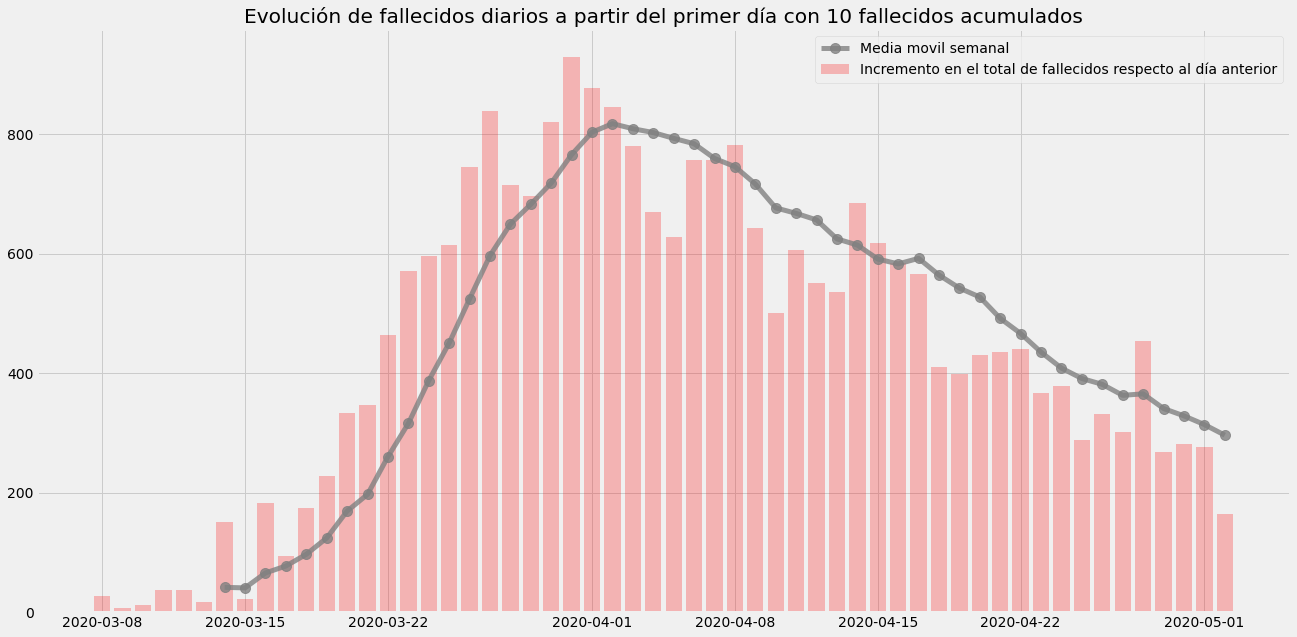

In [9]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_sem['Diferencia fallecidos dia anterior'],alpha=1.8,color='grey',
         label='Media movil semanal',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Diferencia fallecidos dia anterior"],width=0.8, alpha=0.25, color='red',
       label='Incremento en el total de fallecidos respecto al día anterior')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de fallecidos diarios a partir del primer día con 10 fallecidos acumulados')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\fallecidos.png');



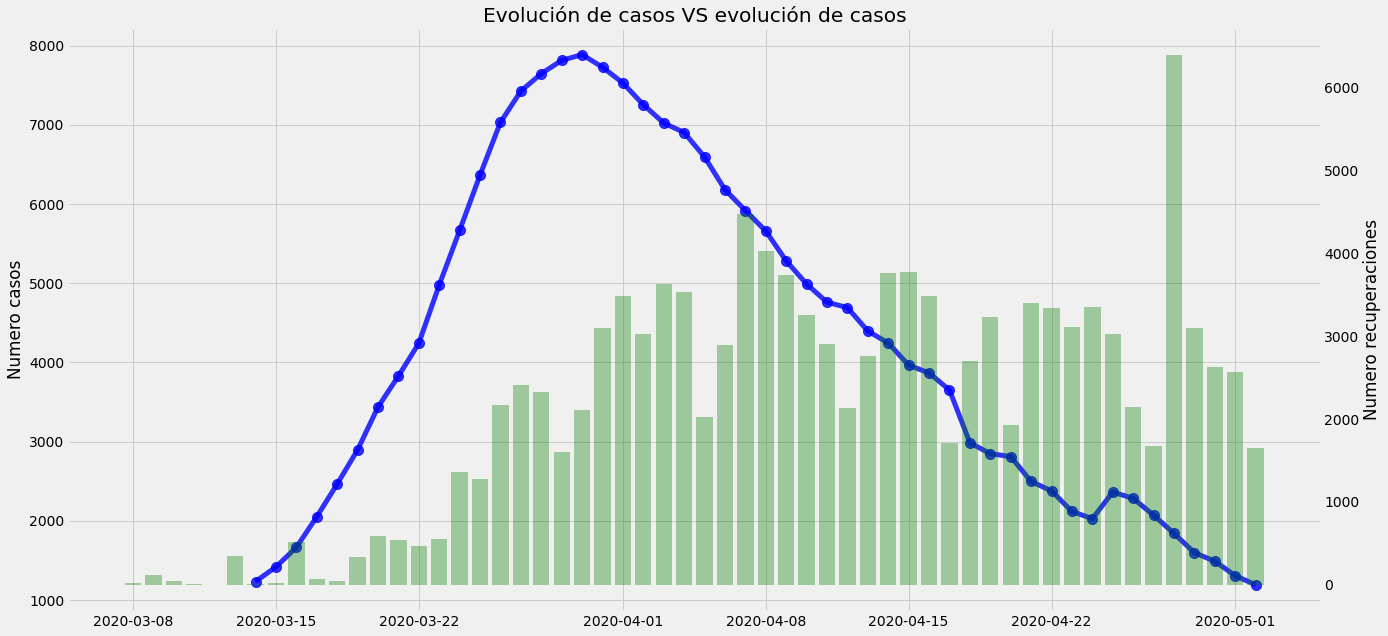

In [10]:
# Let's build our plot
# Set up plot 

fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()  # set up the 2nd axis

#Next lines plot the line of the plot

ax1.plot(data_sem['Diferencia casos dia anterior'],alpha=0.8,color='blue',
         label='Incremento en el total de casos respecto al día anterior',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_sem.index, data_es["Diferencia recuperados dia anterior"],width=0.8, alpha=0.35, color='green',
       label='Incremento en el total de recuperados respecto al día anterior')


ax2.grid(b=False) # turn off grid #2

ax1.set_title('Evolución de casos VS evolución de casos')
ax1.set_ylabel('Numero casos')
ax2.set_ylabel('Numero recuperaciones');



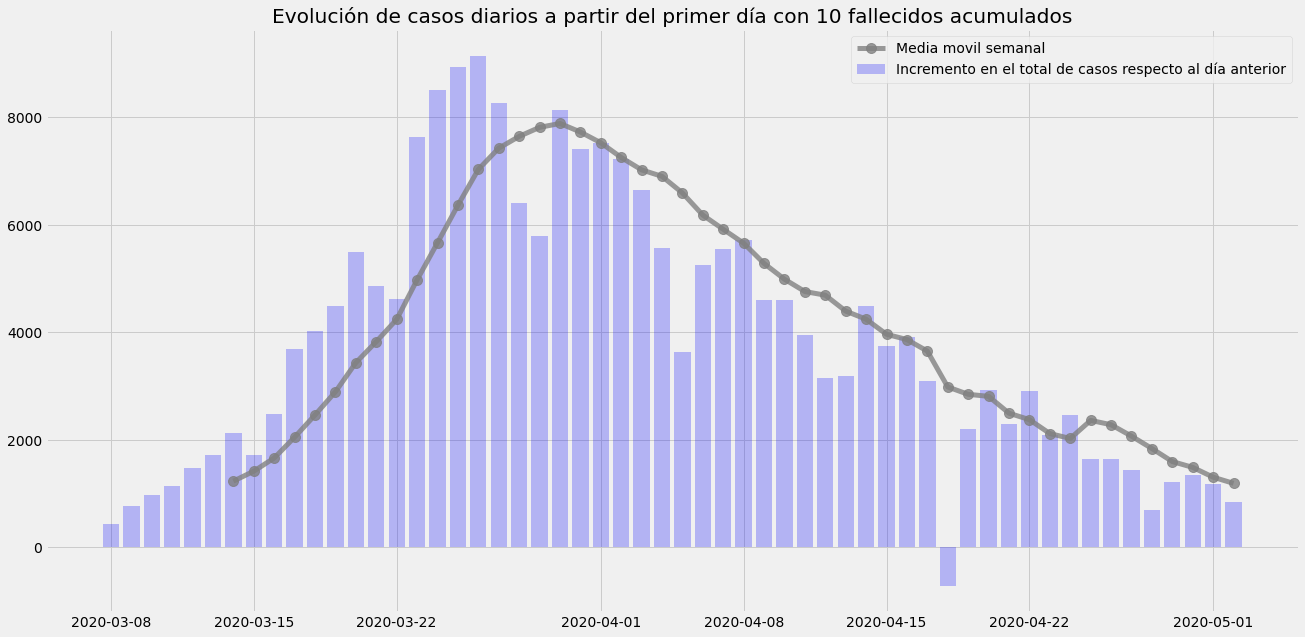

In [11]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_sem['Diferencia casos dia anterior'],alpha=1.8,color='grey',
         label='Media movil semanal',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Diferencia casos dia anterior"],width=0.8, alpha=0.25, color='blue',
       label='Incremento en el total de casos respecto al día anterior')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de casos diarios a partir del primer día con 10 fallecidos acumulados')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\casos.png');




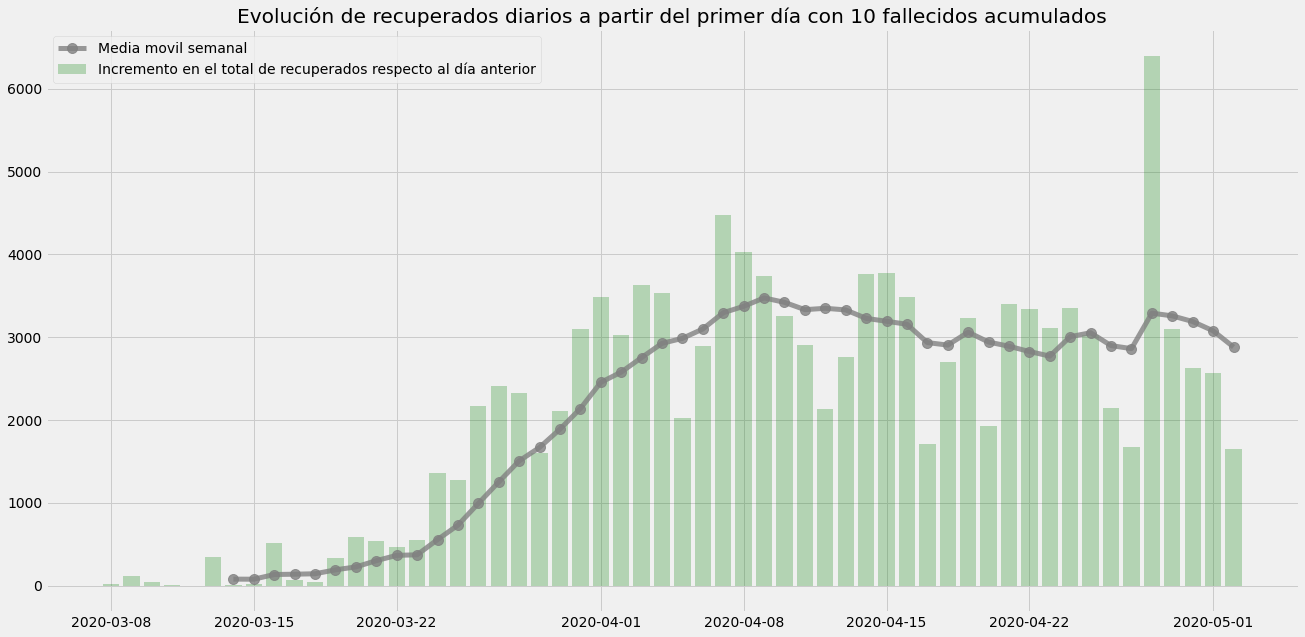

In [12]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_sem['Diferencia recuperados dia anterior'],alpha=1.8,color='grey',
         label='Media movil semanal',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Diferencia recuperados dia anterior"],width=0.8, alpha=0.25, color='green',
       label='Incremento en el total de recuperados respecto al día anterior')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de recuperados diarios a partir del primer día con 10 fallecidos acumulados')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\recuperados.png');


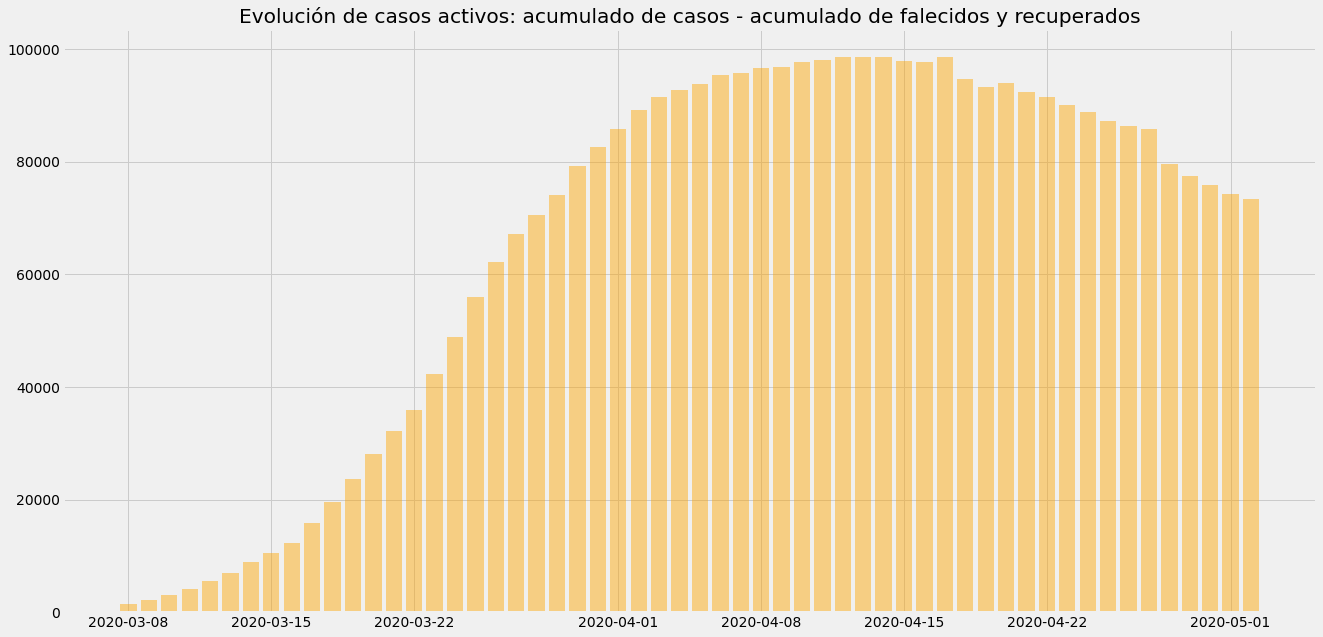

In [13]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Casos"] - data_es["Fallecidos"] - data_es["Recuperados"],
        width=0.8, alpha=0.45, color='orange')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de casos activos: acumulado de casos - acumulado de falecidos y recuperados')
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\casos_activos.png');


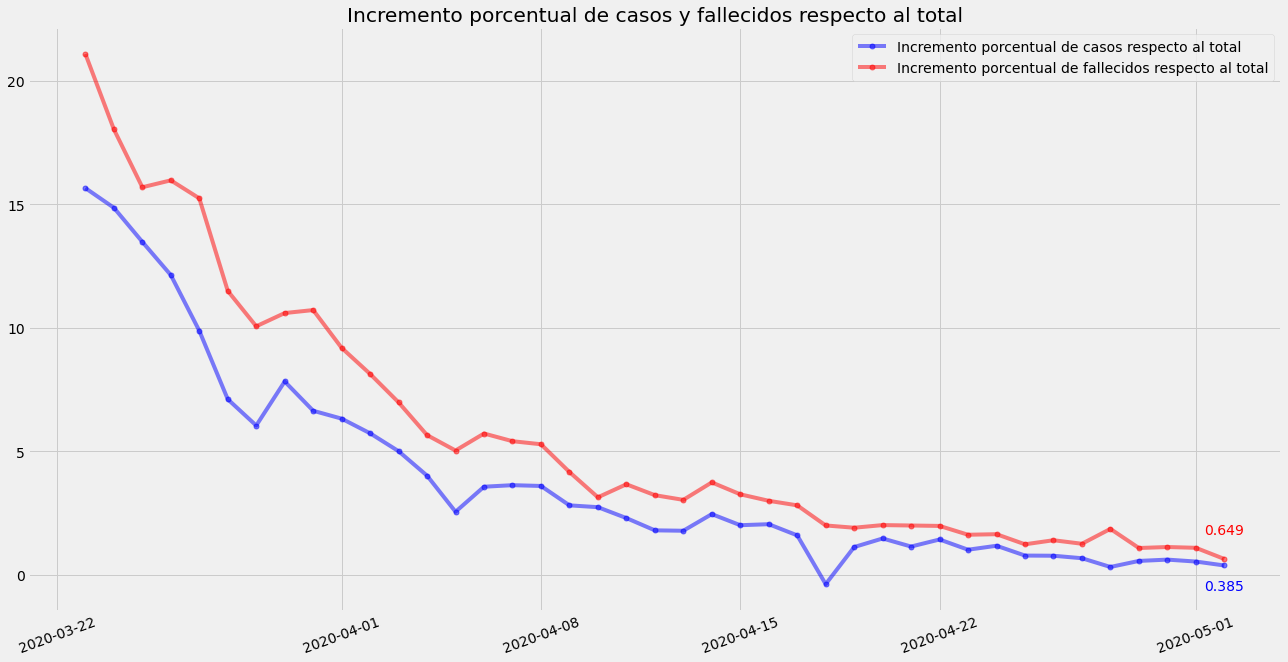

In [14]:
start, end = '2020-03-23 00:00:00', data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-',alpha=0.5,color='blue',
        label='Incremento porcentual de casos respecto al total')

ax.plot(data_es.loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, alpha=0.5,color='red',linestyle='-', label='Incremento porcentual de fallecidos respecto al total')

plt.xticks(rotation=20)
plt.title("Incremento porcentual de casos y fallecidos respecto al total")

plt.annotate(data_es.loc[end, 'Incremento porcentual de casos respecto al total'], # this is the text
                 (end,data_es.loc[end, 'Incremento porcentual de casos respecto al total']), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-25), # distance from text to points (x,y)
                 ha='center',color='blue') # horizontal alignment can be left, right or center
plt.annotate(data_es.loc[end, 'Incremento porcentual de fallecidos respecto al total'], # this is the text
                 (end,data_es.loc[end, 'Incremento porcentual de fallecidos respecto al total']), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,25), # distance from text to points (x,y)
                 ha='center',color='red') # horizontal alignment can be left, right or center

ax.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\incremento_porcentual.png');


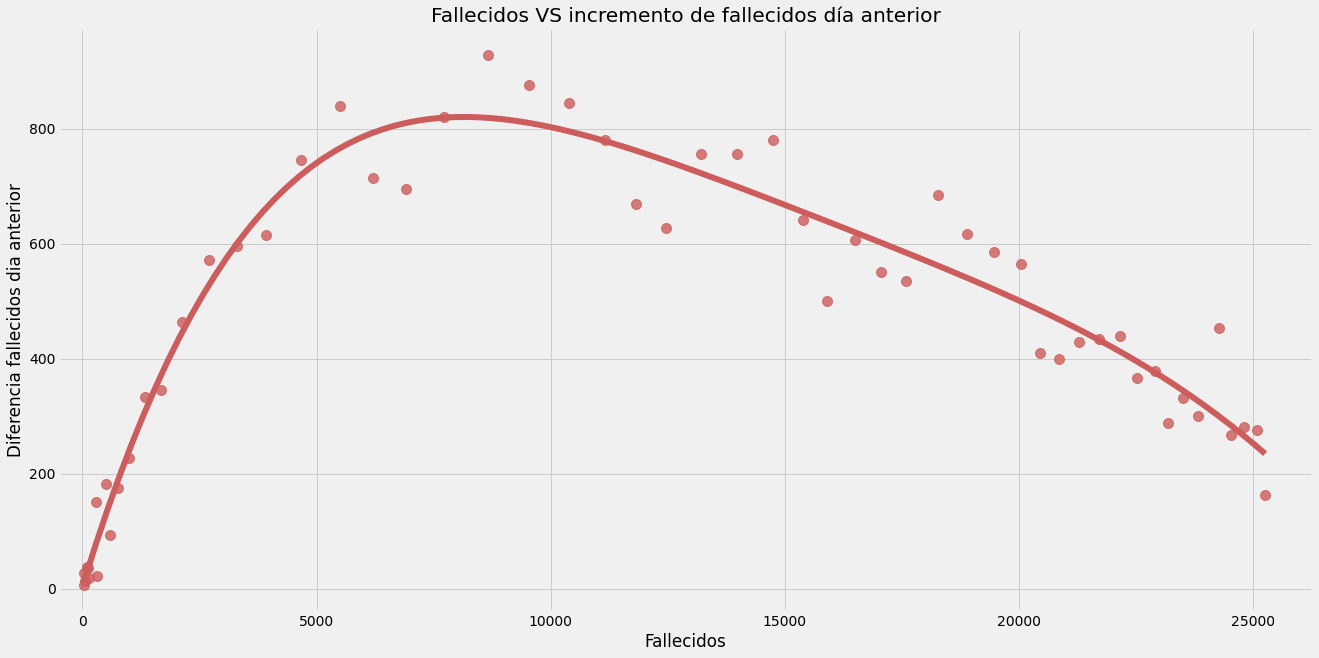

In [15]:
fig, ax = plt.subplots(figsize=(20,10))

start, end = data_es.index.min(), data_es.index.max()
X = data_es.loc[start:end, 'Fallecidos']
Y = data_es.loc[start:end, 'Diferencia fallecidos dia anterior']

ax = sns.regplot(x=X, y=Y, data=data_es,scatter_kws={"s": 100},order=5, ci=False,color='indianred')
plt.title("Fallecidos VS incremento de fallecidos día anterior")
ax.set(xlim=(-500, data_es["Fallecidos"].max() + 1000))
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\fallecidos_VS_incremento.png');



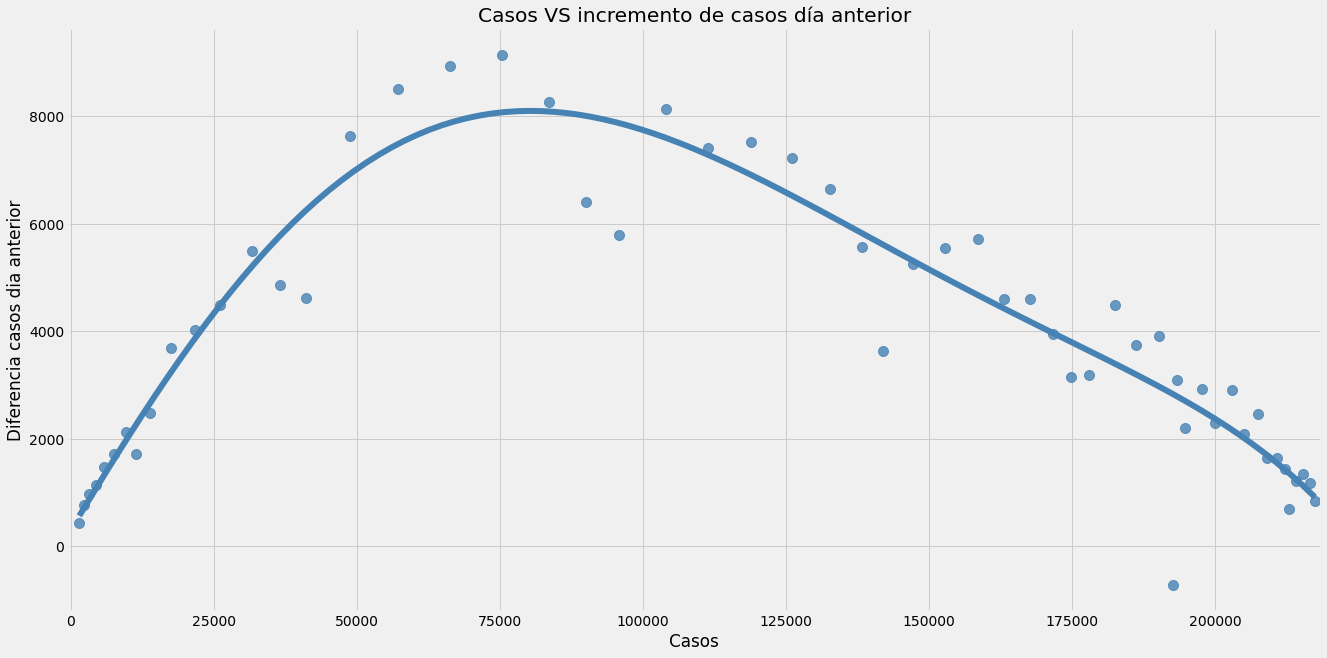

In [16]:
fig, ax = plt.subplots(figsize=(20,10))

start, end = data_es.index.min(), data_es.index.max()
X = data_es.loc[start:end, 'Casos']
Y = data_es.loc[start:end, 'Diferencia casos dia anterior']

ax = sns.regplot(x=X, y=Y, data=data_es,scatter_kws={"s": 100},order=5, ci=True,color='steelblue')
ax.set(xlim=(-500, data_es["Casos"].max() + 1000))

plt.title("Casos VS incremento de casos día anterior")
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\casos_VS_incremento.png');



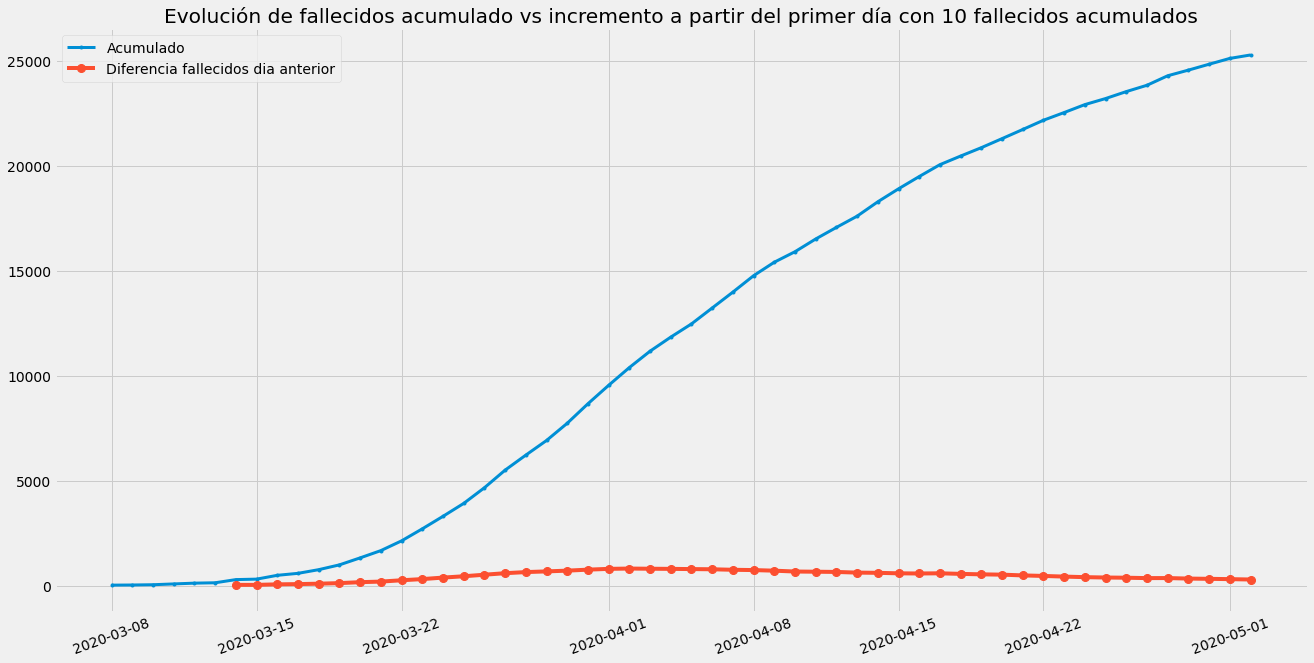

In [17]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Fallecidos'],
marker='.', linestyle='-', linewidth=3, label='Acumulado')
ax.plot(data_sem.loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=8, linestyle='-', label='Diferencia fallecidos dia anterior')
plt.xticks(rotation=20)
plt.title("Evolución de fallecidos acumulado vs incremento a partir del primer día con 10 fallecidos acumulados")
ax.legend();

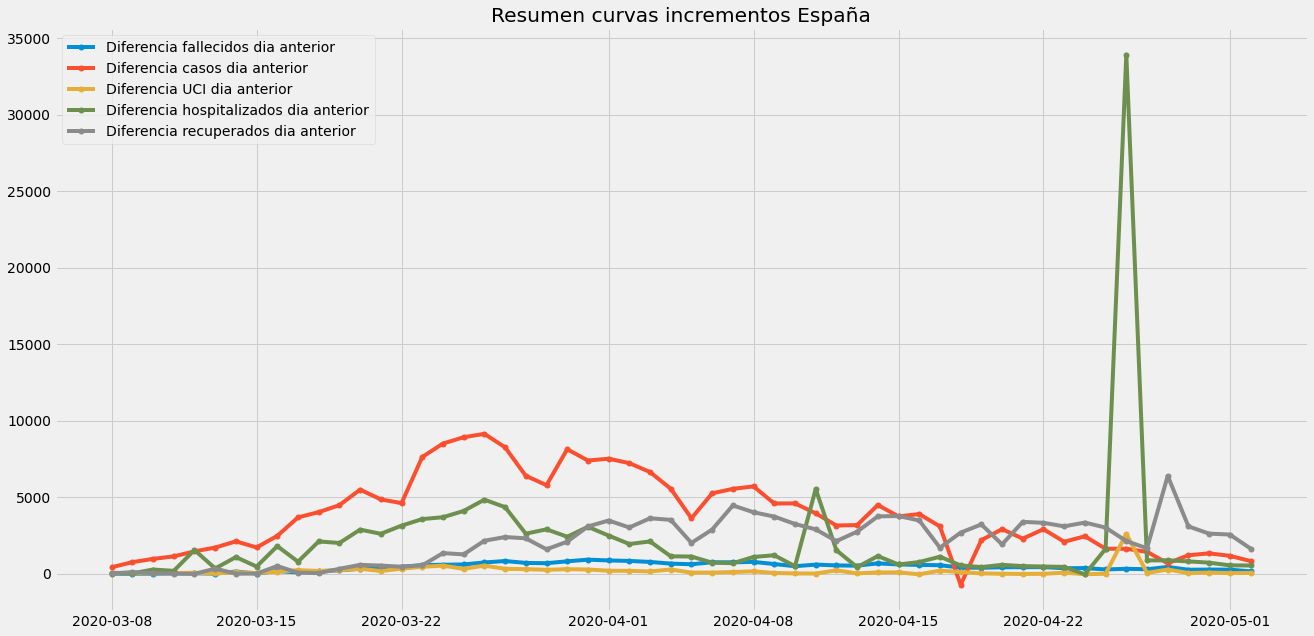

In [18]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia fallecidos dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia casos dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia UCI dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia UCI dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia hospitalizados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia hospitalizados dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia recuperados dia anterior')
plt.title("Resumen curvas incrementos España");
ax.legend();

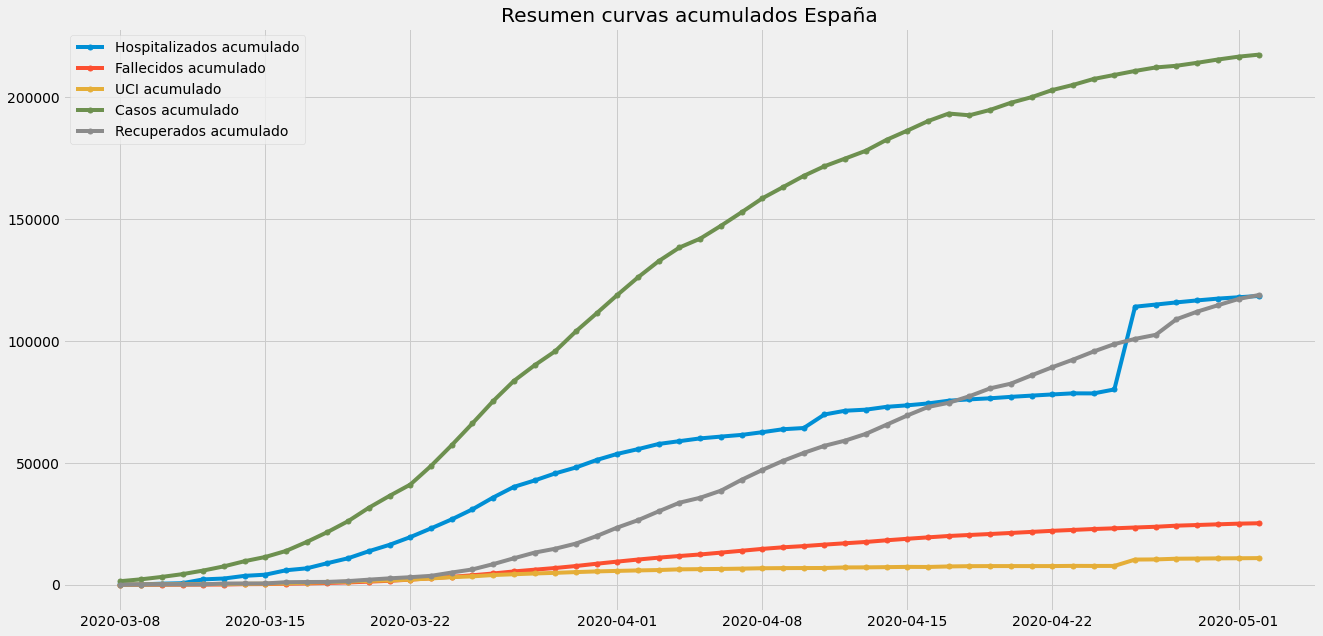

In [19]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(data_es.loc[start:end, 'Hospitalizados'],
marker='o', markersize=5, linestyle='-', label='Hospitalizados acumulado')
ax.plot(data_es.loc[start:end, 'Fallecidos'],
marker='o', markersize=5, linestyle='-', label='Fallecidos acumulado')
ax.plot(data_es.loc[start:end, 'UCI'],
marker='o', markersize=5, linestyle='-', label='UCI acumulado')
ax.plot(data_es.loc[start:end, 'Casos'],
marker='o', markersize=5, linestyle='-', label='Casos acumulado')
ax.plot(data_es.loc[start:end, 'Recuperados'],
marker='o', markersize=5, linestyle='-', label='Recuperados acumulado')
plt.title("Resumen curvas acumulados España");
ax.legend();

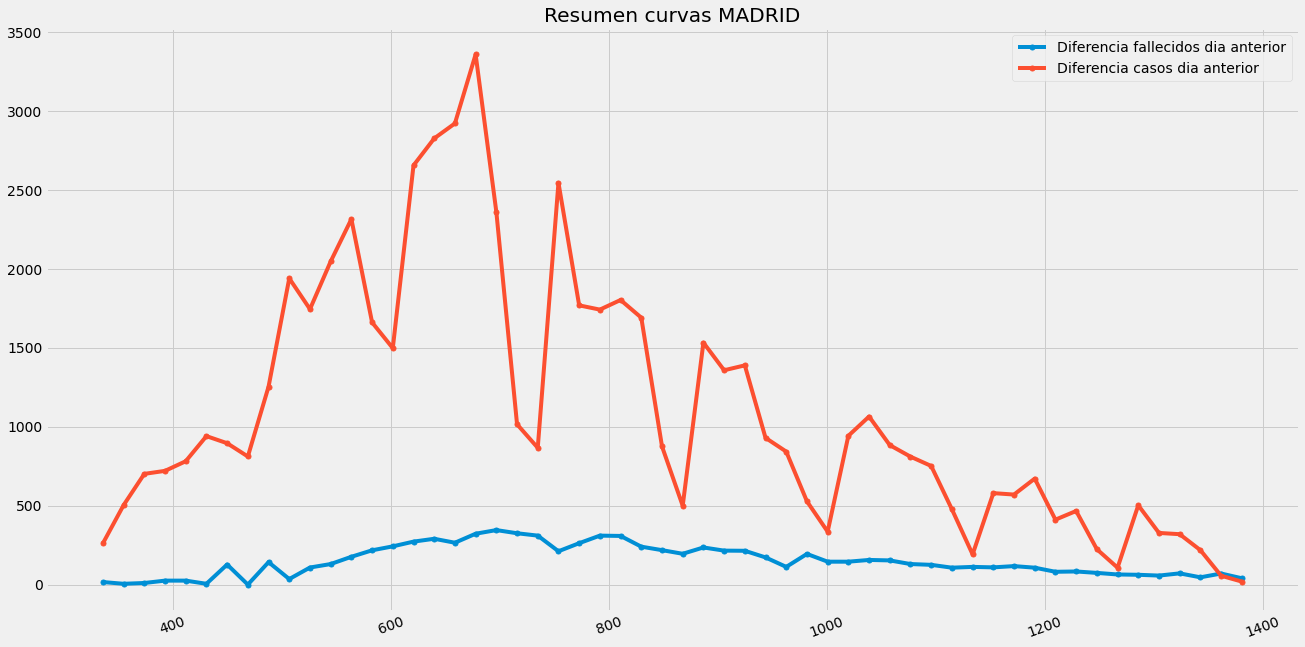

In [20]:
#Introducir código ISO de la comunidad a analizar (ejemplo Asturias) 
data = data[data["Fallecidos"] > 10]

start, end = data[data["CCAA Codigo ISO"] == "MD"].index.min(), data[data["CCAA Codigo ISO"] == "MD"].index.max()
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data[data["CCAA Codigo ISO"] == "MD"].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia fallecidos dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "MD"].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia casos dia anterior')

ax.legend()
plt.xticks(rotation=20)
plt.title("Resumen curvas MADRID");

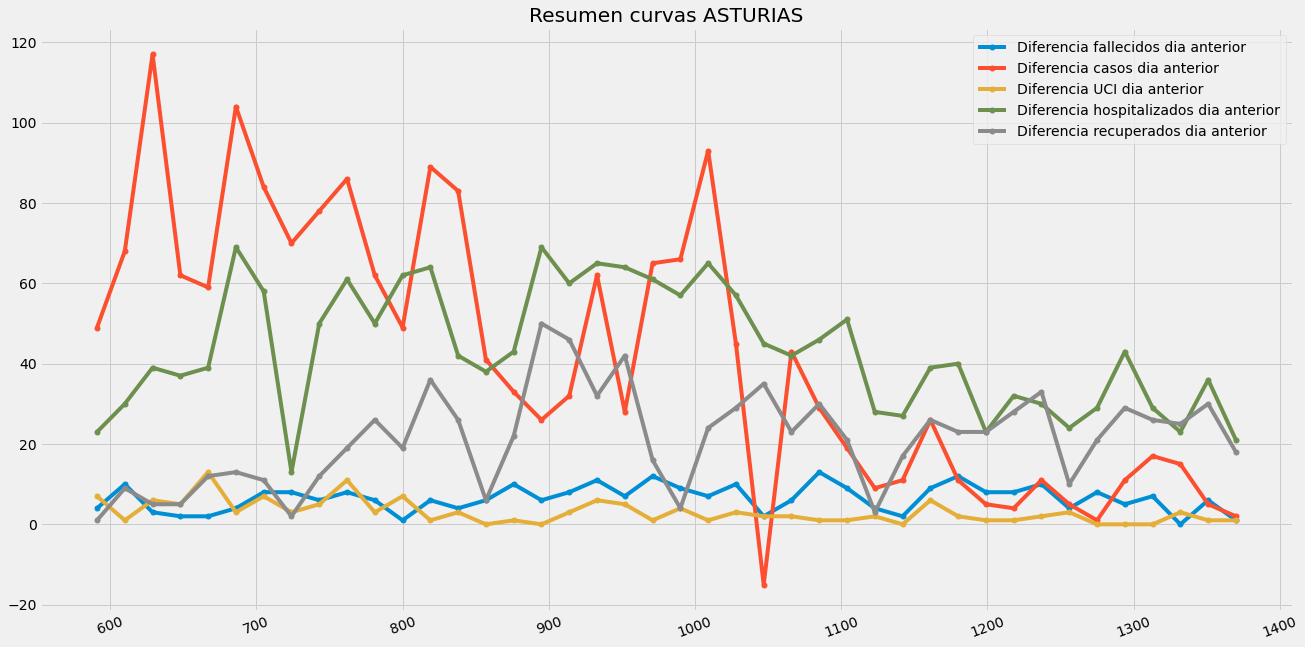

In [21]:
#Introducir código ISO de la comunidad a analizar (ejemplo Asturias) 
data = data[data["Fallecidos"] > 10]

start, end = data[data["CCAA Codigo ISO"] == "AS"].index.min(), data[data["CCAA Codigo ISO"] == "AS"].index.max()
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia fallecidos dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia casos dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia UCI dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia UCI dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia hospitalizados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia hospitalizados dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia recuperados dia anterior')
ax.legend()
plt.xticks(rotation=20)
plt.title("Resumen curvas ASTURIAS");

Casos positivos: 57387.0
Casos Sospechosos: 133575.059
Numero de tests totales: 190962.059


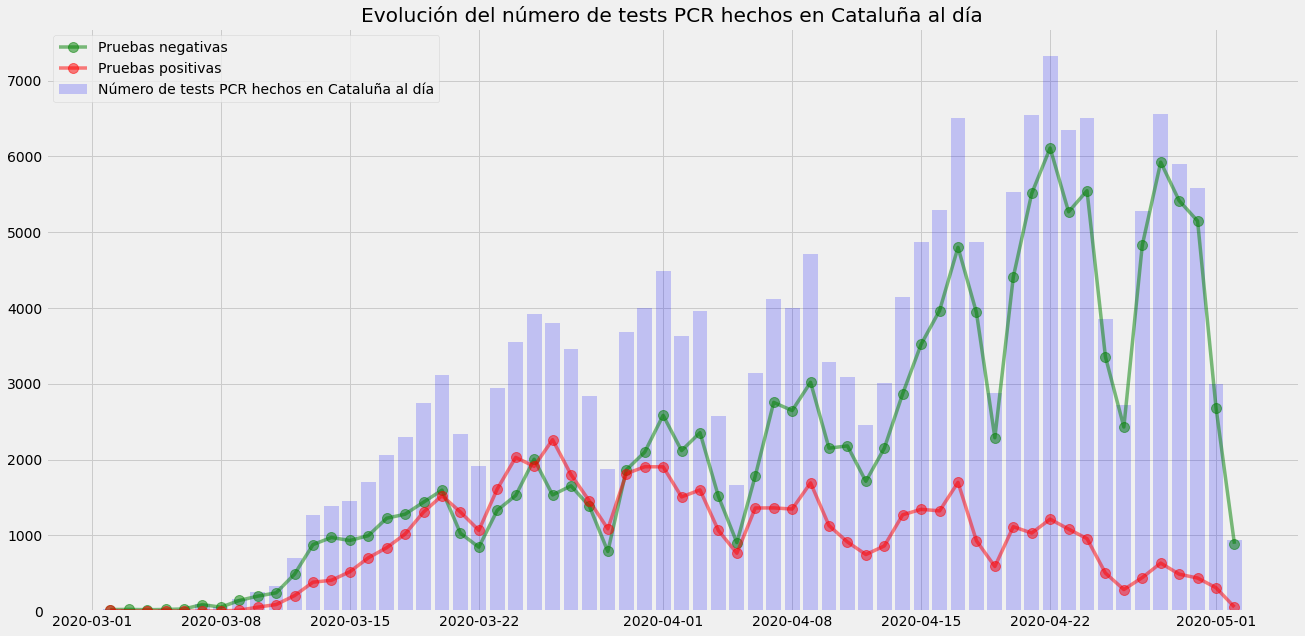

In [22]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_cat_gropued_resultado[data_cat_gropued_resultado['TipusCasDescripcio'] == "Sospitós"]["NumCasos"]
         ,alpha=0.5,color='green',
         label='Pruebas negativas',marker='o', markersize=10,linewidth=3.5)

ax1.plot(data_cat_gropued_resultado[data_cat_gropued_resultado['TipusCasDescripcio'] == "Positiu"]["NumCasos"]
         ,alpha=0.5,color='red',
         label='Pruebas positivas',marker='o', markersize=10,linewidth=3.5)


#Next lines plot the bar chat part of the plot
ax2.bar(data_cat_gropued.index, data_cat_gropued["NumCasos"],width=0.8, alpha=0.2, color='blue',
       label='Número de tests PCR hechos en Cataluña al día')

ax1.grid(b=True) #Turn on grid

print ("Casos positivos:", data_cat_gropued_resultado[data_cat_gropued_resultado['TipusCasDescripcio'] == "Positiu"]["NumCasos"].sum())
print ("Casos Sospechosos:", data_cat_gropued_resultado[data_cat_gropued_resultado['TipusCasDescripcio'] == "Sospitós"]["NumCasos"].sum())
print ("Numero de tests totales:", data_cat_gropued_resultado["NumCasos"].sum())

#set up the title and legend
ax1.set_title('Evolución del número de tests PCR hechos en Cataluña al día')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\tests.png');



In [23]:
data_sem_jh = data_sem_jh[data_sem_jh["Fallecidos"] >= 10]
data_sem_jh = data_sem_jh.reset_index()
data_sem_jh = data_sem_jh.set_index('Fecha')
data_sem_jh = data_sem_jh.reset_index()
data_sem_jh["Time_delta"] = 0
data_sem_jh["Time_delta"] = pd.to_timedelta(data_sem_jh["Time_delta"])


In [24]:
for geo in data_sem_jh["Country/Region"].unique():
    data_sem_out = data_sem_jh[data_sem_jh["Country/Region"] == geo]
    data_sem_out["Time_delta"] = data_sem_out[data_sem_out["Country/Region"] == geo]["Fecha"] - data_sem_out[data_sem_out["Country/Region"] == geo]["Fecha"].min()
    data_sem_jh[data_sem_jh["Country/Region"] == geo] = data_sem_out[data_sem_out["Country/Region"] == geo]

In [25]:
data_sem_jh["Time_delta"] = data_sem_jh["Time_delta"].astype('timedelta64[D]')
data_sem_jh = data_sem_jh.set_index('Time_delta')


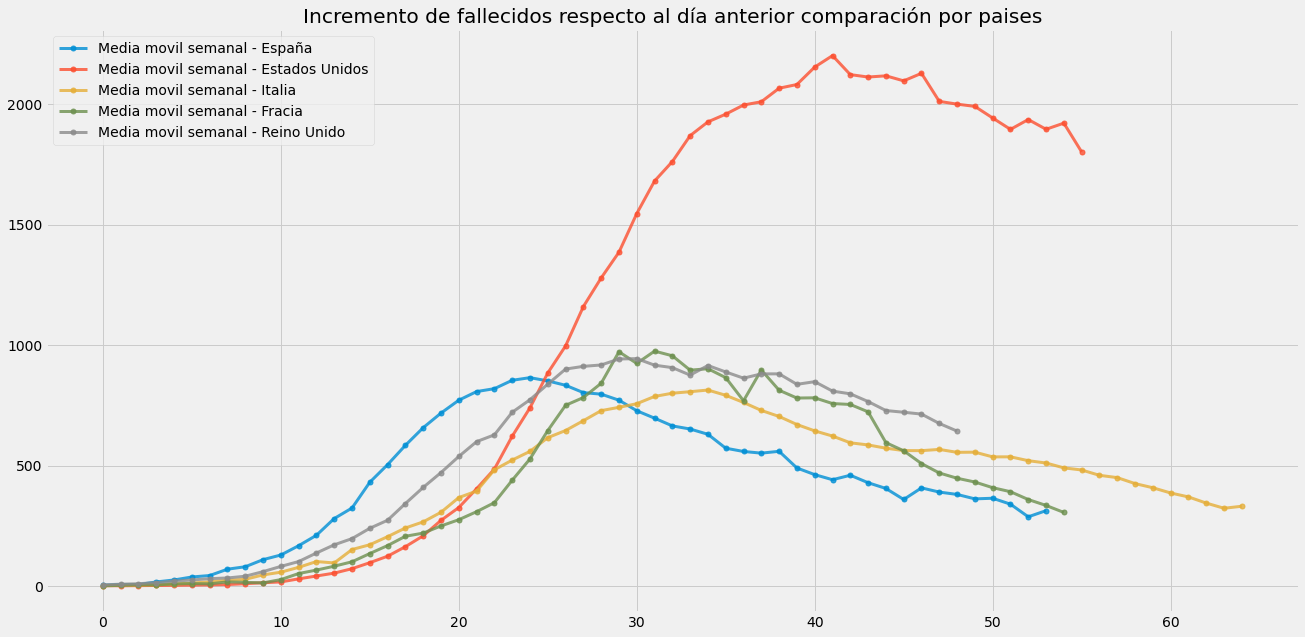

In [26]:
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o', alpha=0.8,linewidth=3, markersize=5, linestyle='-', label='Media movil semanal - España')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o', alpha=0.8,linewidth=3,markersize=5, linestyle='-', label='Media movil semanal - Estados Unidos')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o',alpha=0.8,linewidth=3, markersize=5, linestyle='-', label='Media movil semanal - Italia')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o',alpha=0.8 ,linewidth=3,markersize=5, linestyle='-', label='Media movil semanal - Fracia')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") 
                    & (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o',alpha=0.8,linewidth=3, markersize=5, linestyle='-', label='Media movil semanal - Reino Unido')

plt.title("Incremento de fallecidos respecto al día anterior comparación por paises")
ax.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\paises.png');

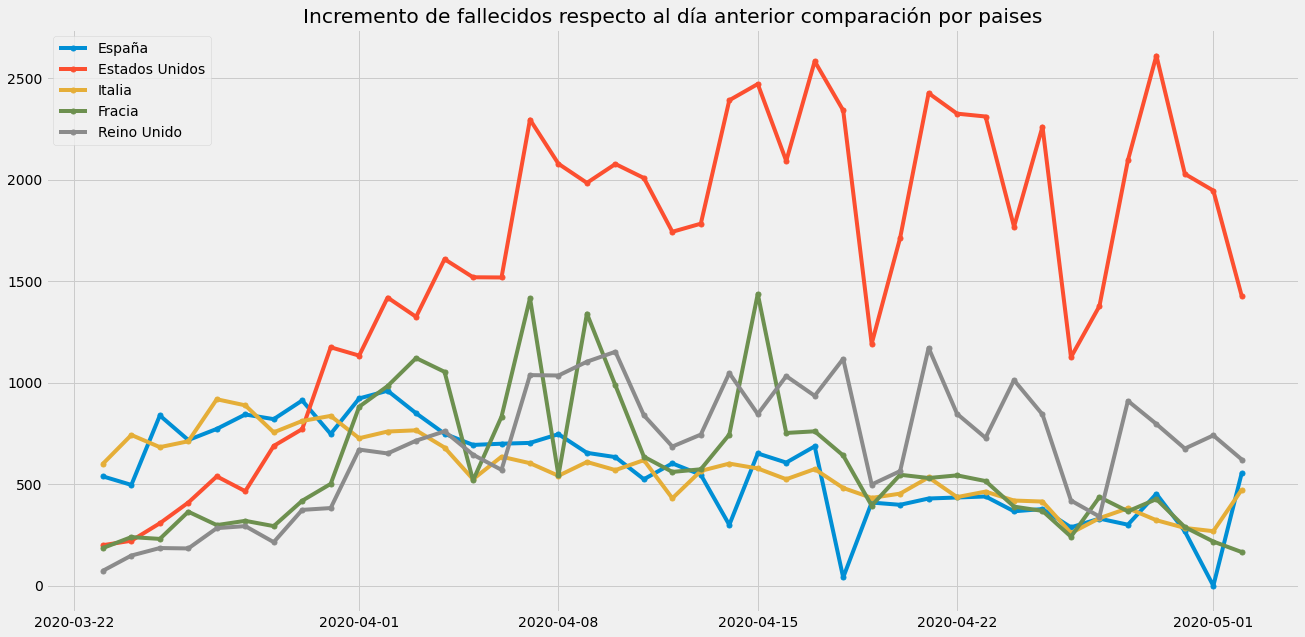

In [27]:
start, end = '2020-03-23 00:00:00', data_jh[(data_jh["Country/Region"] == "Spain") & (data_jh["Fallecidos"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_jh[(data_jh["Country/Region"] == "Spain") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_jh[(data_jh["Country/Region"] == "US") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_jh[(data_jh["Country/Region"] == "Italy") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_jh[(data_jh["Country/Region"] == "France") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_jh[(data_jh["Country/Region"] == "United Kingdom") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento de fallecidos respecto al día anterior comparación por paises");
ax.legend();

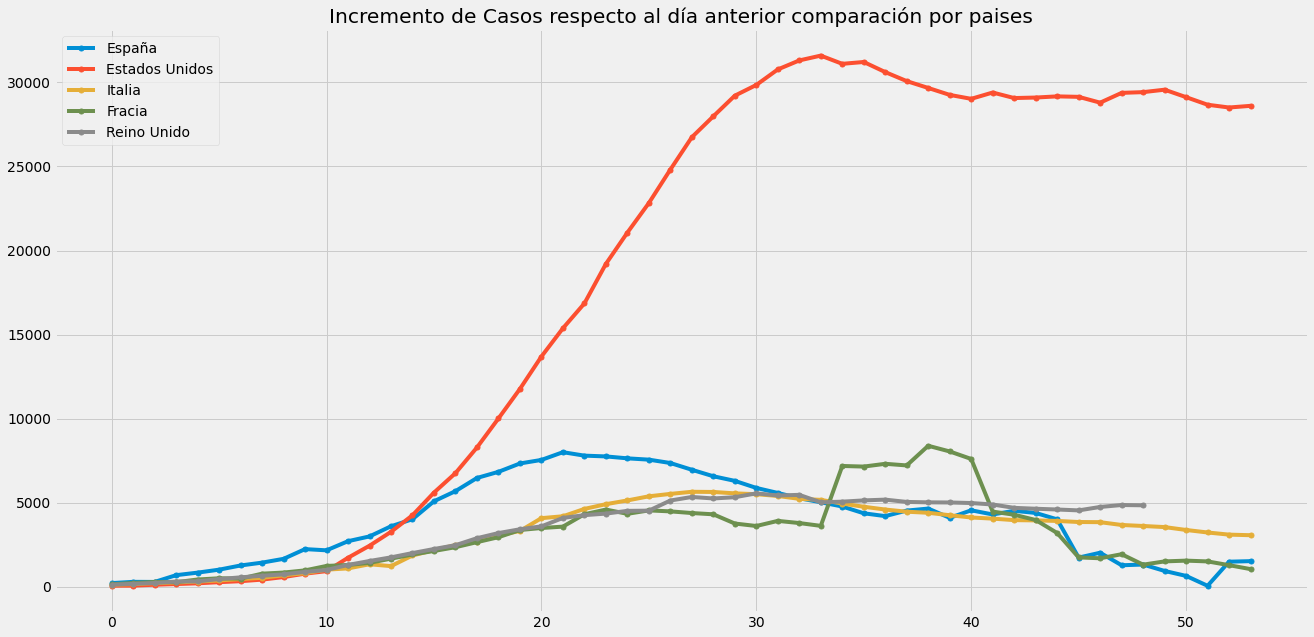

In [28]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento de Casos respecto al día anterior comparación por paises");
ax.legend();

In [29]:
data_jh[["Country/Region","Diferencia casos dia anterior"]].sort_values("Diferencia casos dia anterior",
                                                                            ascending=False).head(10)

,Country/Region,Diferencia casos dia anterior
Fecha,,
2020-04-24,US,36188.0
2020-04-09,US,34126.0
2020-05-01,US,34037.0
2020-04-10,US,33755.0
2020-04-04,US,33283.0
2020-04-25,US,32796.0
2020-04-18,US,32491.0
2020-04-17,US,32114.0
2020-04-03,US,31745.0


In [30]:
data_jh[["Country/Region","Diferencia fallecidos dia anterior"]].sort_values("Diferencia fallecidos dia anterior",
                                                                            ascending=False).head(10)

,Country/Region,Diferencia fallecidos dia anterior
Fecha,,
2020-04-29,US,2612.0
2020-04-17,US,2584.0
2020-04-15,US,2472.0
2020-04-21,US,2427.0
2020-04-14,US,2392.0
2020-04-18,US,2342.0
2020-04-22,US,2326.0
2020-04-23,US,2312.0
2020-04-07,US,2297.0


In [31]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

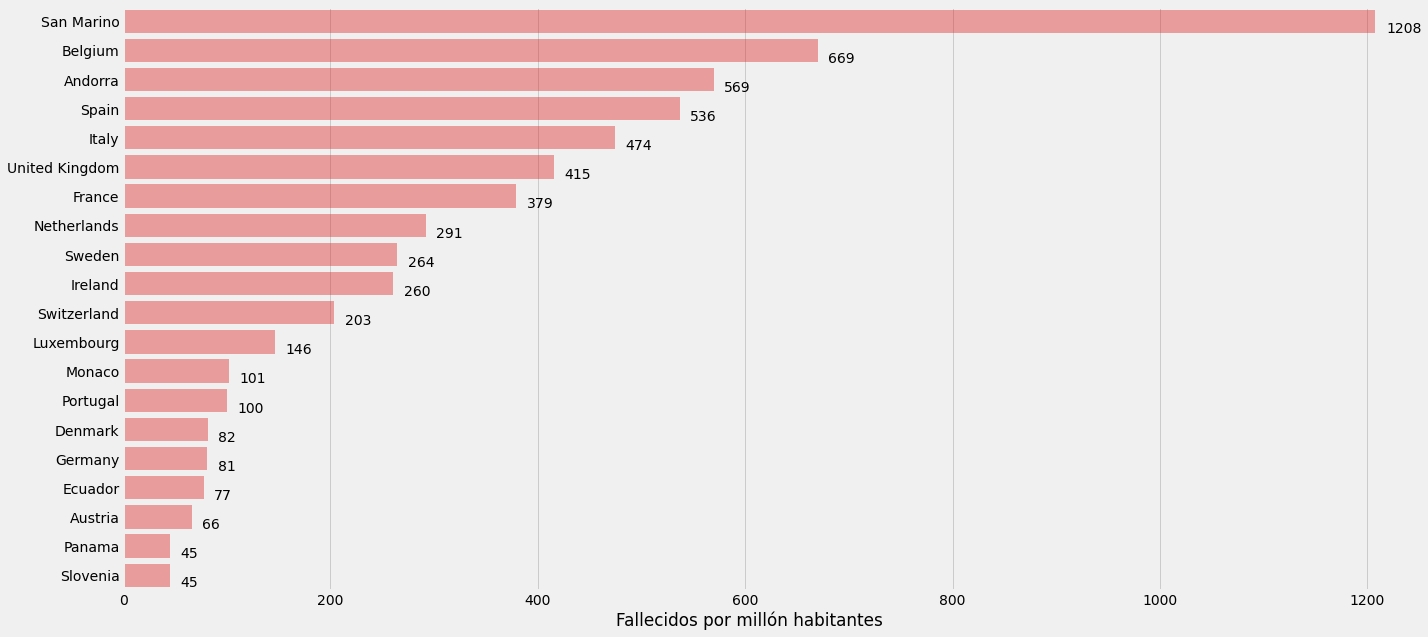

In [32]:

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(20,10))

# Load the example car crash dataset
df = data_jh.groupby(["Country/Region"]).max()["Fallecidos por millón habitantes"].sort_values(ascending=False).to_frame().reset_index().head(20)

# Plot the total crashes
sns.barplot(x="Fallecidos por millón habitantes", y="Country/Region", data=df,
            label="Total", color="r", alpha=0.4)



# Add a legend and informative axis label
ax.set(xlim=(0, df["Fallecidos por millón habitantes"].max()), ylabel="",
       xlabel="Fallecidos por millón habitantes")
show_values_on_bars(ax, "h", 10);


In [33]:
fecha = data_jh.index.max()

df = data_jh[data_jh["Fallecidos"] > 25].loc[fecha, ["Country/Region","Fallecidos",
                                                'Incremento porcentual de fallecidos respecto al total']].sort_values(by='Incremento porcentual de fallecidos respecto al total',
                                                                                                                      ascending=False).head(10)
df["Días que tarda en doblar fallecidos"] = 100/df["Incremento porcentual de fallecidos respecto al total"]

df["Días que tarda en doblar fallecidos"] = df["Días que tarda en doblar fallecidos"].round(3)
df["Incremento porcentual de fallecidos respecto al total"] = df["Incremento porcentual de fallecidos respecto al total"].round(3)

df

,Country/Region,Fallecidos,Incremento porcentual de fallecidos respecto al total,Días que tarda en doblar fallecidos
Fecha,,,,
2020-05-02,Ecuador,1371,22.465,4.451
2020-05-02,Nigeria,85,20.000,5.000
2020-05-02,Sudan,41,12.195,8.200
2020-05-02,Somalia,31,9.677,10.333
2020-05-02,Kuwait,33,9.091,11.000
2020-05-02,India,1323,7.559,13.230
2020-05-02,United Arab Emirates,119,6.723,14.875
2020-05-02,Peru,1200,6.333,15.789
2020-05-02,Niger,35,5.714,17.500


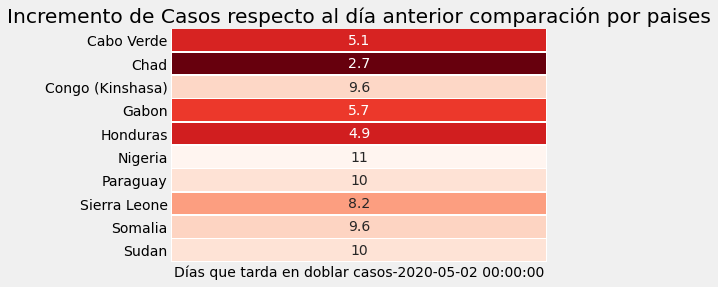

In [34]:
fecha = data_jh.index.max()

df = data_jh[data_jh["Casos"] > 100].loc[fecha, ["Country/Region","Casos",
                                                'Incremento porcentual de casos respecto al total']].sort_values(by='Incremento porcentual de casos respecto al total',
                                                                                                                      ascending=False).head(10)
df["Días que tarda en doblar casos"] = 100/df["Incremento porcentual de casos respecto al total"]

df["Días que tarda en doblar casos"] = df["Días que tarda en doblar casos"].round(3)
df["Incremento porcentual de casos respecto al total"] = df["Incremento porcentual de casos respecto al total"].round(3)
df = df.loc[:, df.columns != 'Casos']
df = df.loc[:, df.columns != 'Incremento porcentual de casos respecto al total']
df = df.sort_values(by='Días que tarda en doblar casos',ascending=False)
df = df.reset_index().pivot("Country/Region","Fecha")
ax = sns.heatmap(df, annot=True,cmap="Reds_r", linewidths=.5,cbar=False)
plt.title("Incremento de Casos respecto al día anterior comparación por paises")
plt.ylabel('')
plt.xlabel('');



In [35]:
df

,Días que tarda en doblar casos
Fecha,2020-05-02
Country/Region,
Cabo Verde,5.067
Chad,2.659
Congo (Kinshasa),9.629
Gabon,5.678
Honduras,4.903
Nigeria,10.954
Paraguay,10.000
Sierra Leone,8.158


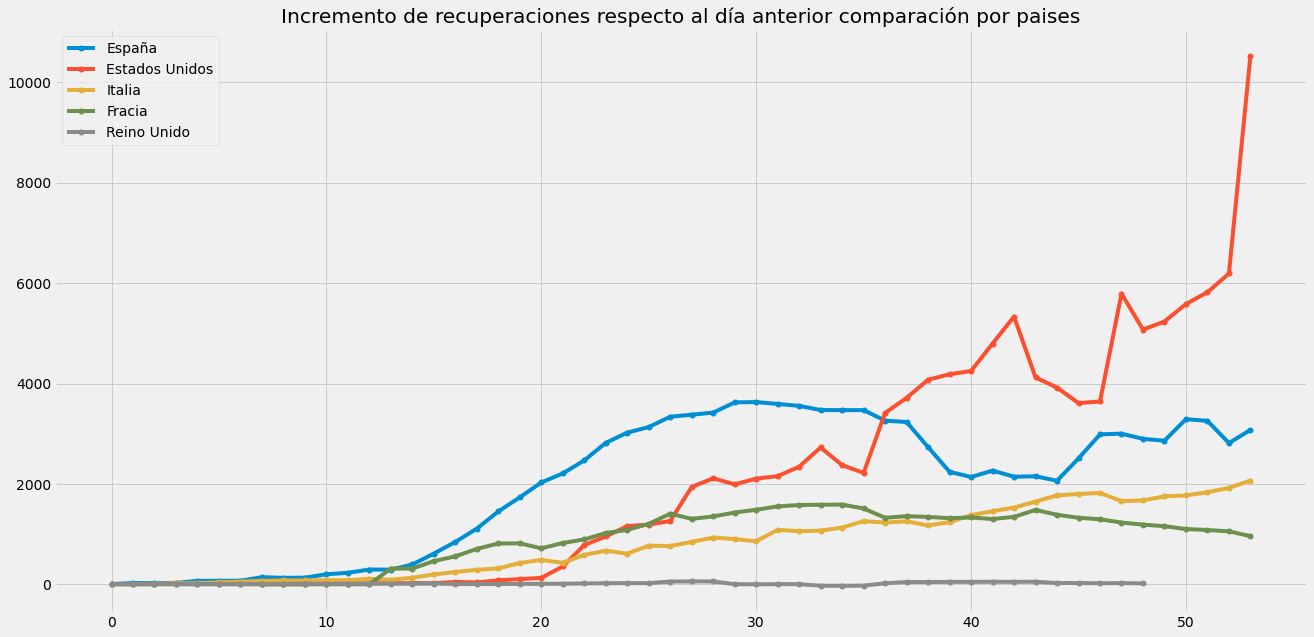

In [36]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento de recuperaciones respecto al día anterior comparación por paises");
ax.legend();

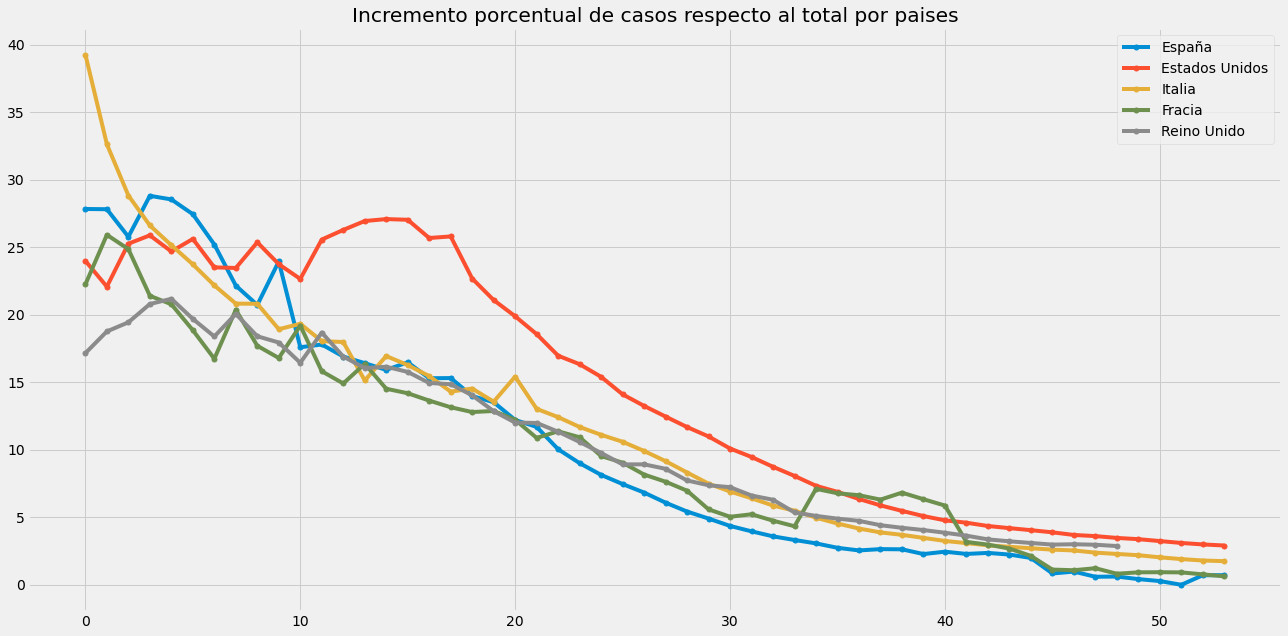

In [37]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Casos"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento porcentual de casos respecto al total por paises");
ax.legend();

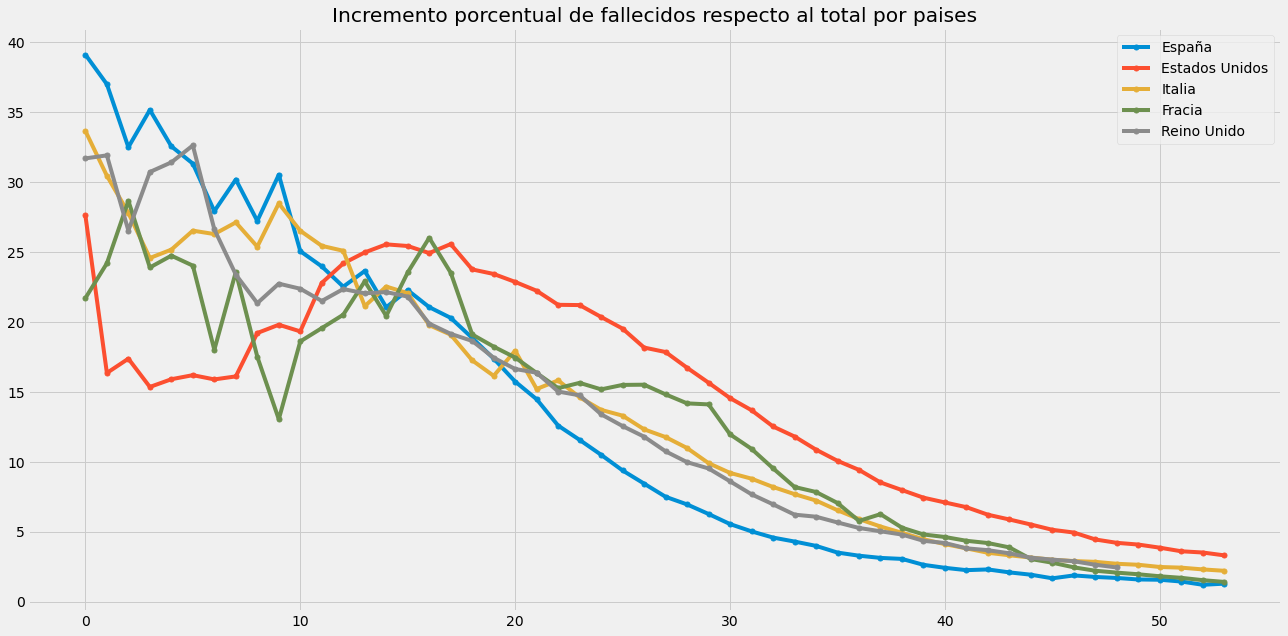

In [38]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento porcentual de fallecidos respecto al total por paises");
ax.legend();

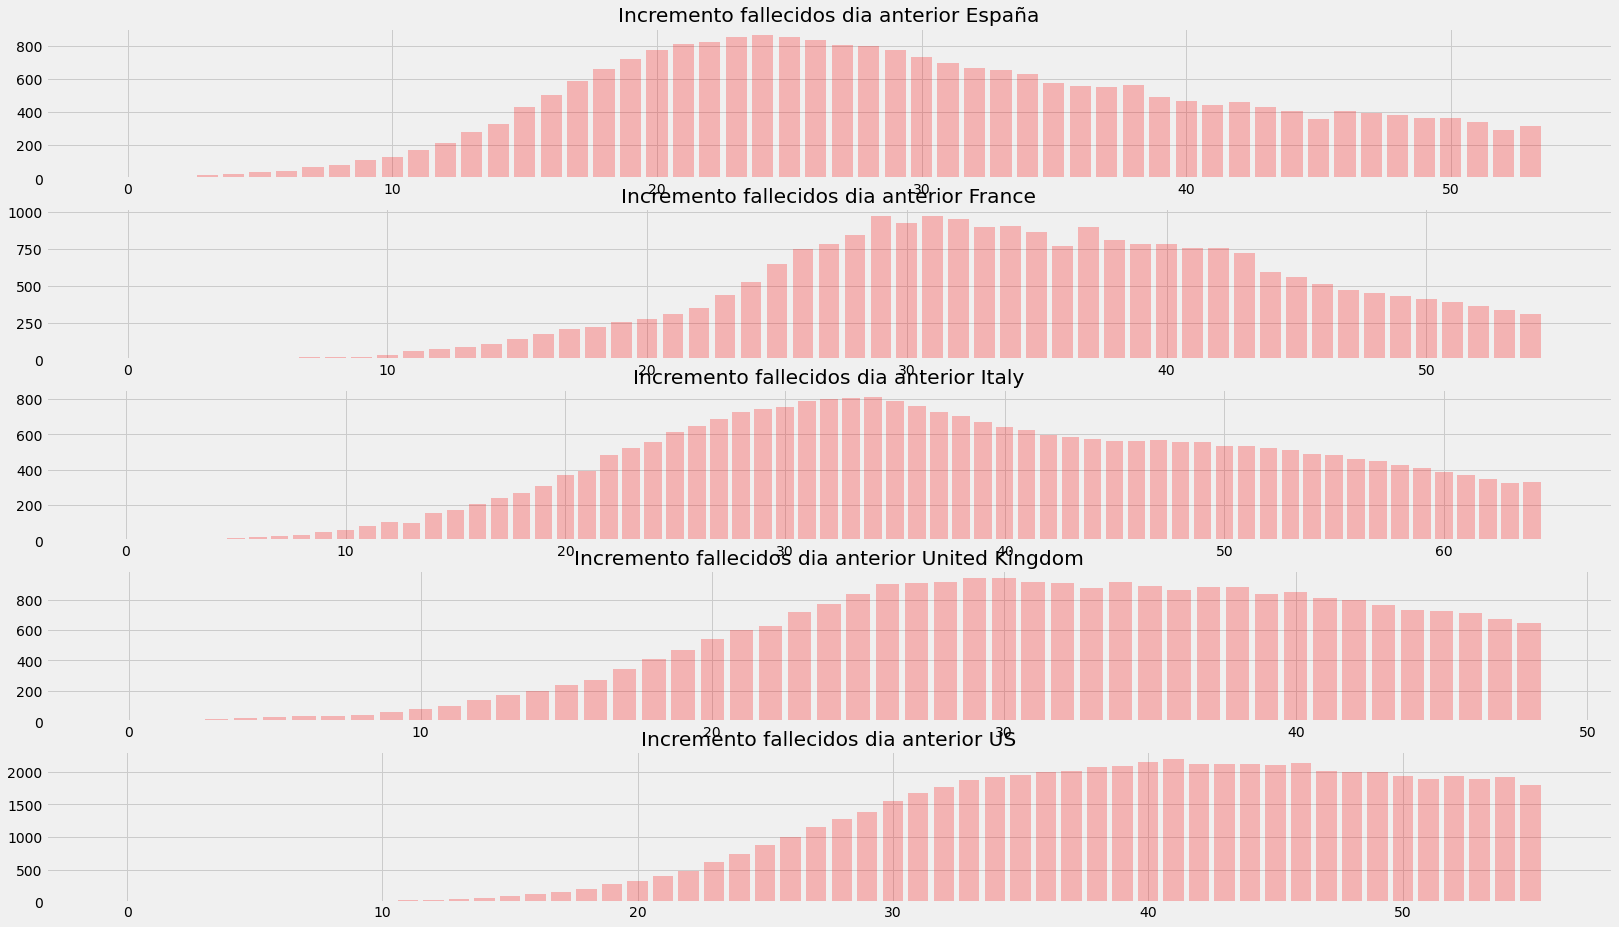

In [39]:
start, end = data_sem_jh.index.min(), data_sem_jh.index.max()
# Let's build our plot
# Set up plot 
fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(5,figsize=(25,15))

#Next lines plot the bar chat part of the plot
ax1.bar(data_sem_jh[data_sem_jh["Country/Region"] == "Spain"].loc[start: end].index, 
        data_sem_jh[data_sem_jh["Country/Region"] == "Spain"]["Diferencia fallecidos dia anterior"].loc[start: end],
        width=0.8, alpha=0.25, color='red')

ax2.bar(data_sem_jh[data_sem_jh["Country/Region"] == "France"].loc[start: end].index, 
        data_sem_jh[data_sem_jh["Country/Region"] == "France"]["Diferencia fallecidos dia anterior"].loc[start: end],
        width=0.8, alpha=0.25, color='red')

ax3.bar(data_sem_jh[data_sem_jh["Country/Region"] == "Italy"].loc[start: end].index, 
        data_sem_jh[data_sem_jh["Country/Region"] == "Italy"]["Diferencia fallecidos dia anterior"].loc[start: end],
        width=0.8, alpha=0.25, color='red')

ax4.bar(data_sem_jh[data_sem_jh["Country/Region"] == "United Kingdom"].loc[start: end].index, 

        data_sem_jh[data_sem_jh["Country/Region"] == "United Kingdom"]["Diferencia fallecidos dia anterior"].loc[start: end],
        width=0.8, alpha=0.25, color='red')

ax5.bar(data_sem_jh[data_sem_jh["Country/Region"] == "US"].loc[start: end].index, 
        data_sem_jh[data_sem_jh["Country/Region"] == "US"]["Diferencia fallecidos dia anterior"].loc[start: end],
        width=0.8, alpha=0.25, color='red')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Incremento fallecidos dia anterior España')
ax2.set_title('Incremento fallecidos dia anterior France')
ax3.set_title('Incremento fallecidos dia anterior Italy')
ax4.set_title('Incremento fallecidos dia anterior United Kingdom')
ax5.set_title('Incremento fallecidos dia anterior US');


In [40]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA


In [41]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
data_sem.index.freq="D"
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(np.log(data_sem["Diferencia fallecidos dia anterior"]),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
                        


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:323.7305525343789
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:250.9783697982985
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:192.01395851042997


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1220.4590210708966
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:208.9078816903339
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:191.71979663261067
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:46.22273726856016


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1047.1013746506574
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:261.0661506980374
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:249.23017076430256
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:132.04764348714158
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1129.5232103760968
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:164.62522271057043


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:179.02177186811022
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:17.62799013202526


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1005.6983805589056
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-45.91962158202591
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-87.10983126449128
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:34.43486783692143
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:nan


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-106.58111920318295
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-106.32757315399645
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-69.30209356242744


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:nan
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:-60.64930354724763
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:-127.83057577015853
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:12.01262783346207


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1616.6067202289992
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-122.87909331145238
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-126.1603078621219
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:-76.55517400066658
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:-74.6145895133313
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:-47.406705404186845


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:-84.57814320242845
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:29.693409134805236


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1274.7067634916982
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-109.90119256428657
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:-110.18250629044186
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:-62.148005423544404


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1145.990589553572
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-60.596951511434554
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:-110.99893023552008
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:14.560937016035055


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1017.8683727114092
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-124.68553716913434
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-114.4946146905261
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:-78.54287088255812


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:893.3702590607982
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-66.98185056683688
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:-155.40785058330164


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:18.31704910115374


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1467.2879243121358
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-163.40721460412254
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:-132.67071045189573
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:-88.81875148580407
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:-61.13228364826395
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-80.55962591524955
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:-180.51123130076698


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:5.099667399652683


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1259.6927909765973


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-169.53682774496727
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:-169.13749494792947
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:-110.56701987464811
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:-93.31570988342065


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [42]:
mod2 = sm.tsa.statespace.SARIMAX(np.log(data_sem["Diferencia fallecidos dia anterior"]),
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results2 = mod2.fit()
print(results2.summary())

C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                       SARIMAX Results                                        
Dep. Variable:     Diferencia fallecidos dia anterior   No. Observations:                   56
Model:               SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                     nan
Date:                                Sun, 03 May 2020   AIC                                nan
Time:                                        11:54:54   BIC                                nan
Sample:                                    03-08-2020   HQIC                               nan
                                         - 05-02-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12   -4.326e+15        nan        nan        nan         nan         nan
sig

Fecha
2020-04-09   NaN
2020-04-10   NaN
2020-04-11   NaN
2020-04-12   NaN
2020-04-13   NaN
2020-04-14   NaN
2020-04-15   NaN
2020-04-16   NaN
2020-04-17   NaN
2020-04-18   NaN
2020-04-19   NaN
2020-04-20   NaN
2020-04-21   NaN
2020-04-22   NaN
2020-04-23   NaN
2020-04-24   NaN
2020-04-25   NaN
2020-04-26   NaN
2020-04-27   NaN
2020-04-28   NaN
2020-04-29   NaN
2020-04-30   NaN
2020-05-01   NaN
2020-05-02   NaN
Freq: D, dtype: float64
2020-05-03   NaN
2020-05-04   NaN
2020-05-05   NaN
2020-05-06   NaN
2020-05-07   NaN
2020-05-08   NaN
2020-05-09   NaN
2020-05-10   NaN
2020-05-11   NaN
2020-05-12   NaN
Freq: D, dtype: float64


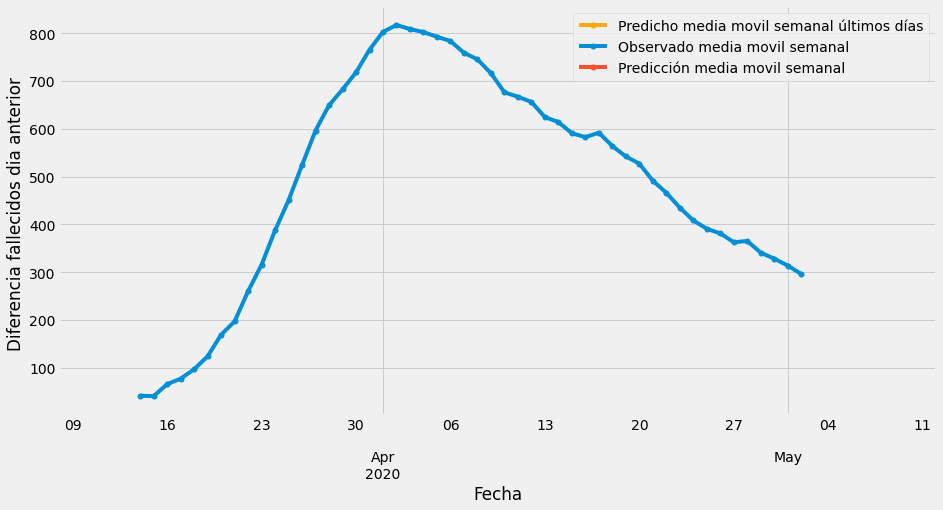

In [43]:
pred_uc_prev = results2.get_prediction(start=pd.to_datetime('2020-04-09 00:00:00'))

pred_uc_prev = math.e**pred_uc_prev.predicted_mean
print(pred_uc_prev)

ax = pred_uc_prev.plot( alpha=.95, figsize=(14, 7),color= "orange",
                       label='Predicho media movil semanal últimos días',marker='o', markersize=5)

pred_uc = results2.get_forecast(steps=10)

pred_ci = pred_uc.conf_int()
pred_ci = math.e**pred_ci
pred_uc = math.e**pred_uc.predicted_mean
ax = data_sem["Diferencia fallecidos dia anterior"].plot(label='Observado media movil semanal', figsize=(14, 7),marker='o', markersize=5)
pred_uc.plot(ax=ax, label='Predicción media movil semanal',marker='o', markersize=5)
print(pred_uc)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Diferencia fallecidos dia anterior ')
plt.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\predicción_media_movil.png');

plt.show()


In [44]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(np.log(data_es["Diferencia fallecidos dia anterior"]),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
                        


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:353.04879411772015
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:251.39701068318377
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:155.5384131896002


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1029.2213394090852
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:162.08316949154178
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:157.58433773060824
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:47.00791249970966


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1248.4441048420276
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:286.6522165515829
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:194.34396679564475
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:121.50605136306169


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1230.3031069761196
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:138.86815493498773
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:129.9324509333067
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:29.964011480539746
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1220.4413485371515
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:93.78343165601555
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-16.780669245222576
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:84.24692158307934
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1450.9386924395035

C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-17.968872926325872
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-14.89745383712312
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:8.342353913959032


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1443.8565405681052
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:78.19828652194644
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:-17.024148072450306
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:68.348257370341


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1407.7402981165094
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-17.309686371837525
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-15.213949959163077
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:9.427487642275029


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1421.4326655659988
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:102.26000380362514


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:-16.09193426697543
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:88.22690745349908


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1198.622082994105
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-16.36093982650454
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:-14.844213123363417
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:7.919902645511422


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1188.313289021956
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:81.58438175532874


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:-13.811824843518934
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:61.45159650328328


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1105.2578910919876
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-15.821385431655237
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-14.767724180053541
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:9.26386551832354


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1095.3929602649077
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:66.77450368907509
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:-16.09651622536709
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:61.630207374470395


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1100.0054517866424
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-16.149389019213604
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:-14.427258034839028
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:10.100007556695903


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1114.0501253862708
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:68.07751430203201
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:-15.194704425948505
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:60.908714692027395


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1181.155851867515
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-15.265761067638167
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:-13.42258466096012
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:11.904968587546875
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1194.8531950001561


C:\Users\guillermo.arguello\AppData\Local\Continuum\anaconda33\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [45]:
mod = sm.tsa.statespace.SARIMAX(np.log(data_es["Diferencia fallecidos dia anterior"]),
                                order=(0, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                       SARIMAX Results                                        
Dep. Variable:     Diferencia fallecidos dia anterior   No. Observations:                   56
Model:                 SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  -2.171
Date:                                Sun, 03 May 2020   AIC                              8.342
Time:                                        11:55:10   BIC                             11.210
Sample:                                    03-08-2020   HQIC                             9.277
                                         - 05-02-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0066      0.110      0.060      0.952      -0.209       0.222
sig

Fecha
2020-04-08    864.143431
2020-04-09    655.624717
2020-04-10    627.569457
2020-04-11    587.297493
2020-04-12    685.918265
2020-04-13    518.656503
2020-04-14    515.221239
2020-04-15    630.745014
2020-04-16    528.726301
2020-04-17    547.937648
2020-04-18    681.760657
2020-04-19    409.479439
2020-04-20    411.411054
2020-04-21    353.385478
2020-04-22    338.284780
2020-04-23    533.380057
2020-04-24    333.205512
2020-04-25    367.092010
2020-04-26    369.442929
2020-04-27    298.093202
2020-04-28    285.575770
2020-04-29    437.599647
2020-04-30    193.825091
2020-05-01    273.411708
2020-05-02    297.529564
Freq: D, dtype: float64
2020-05-03    166.135264
2020-05-04    168.336153
2020-05-05    140.060471
2020-05-06    144.377678
2020-05-07    109.825476
2020-05-08    126.132751
2020-05-09    114.708031
2020-05-10    173.162942
2020-05-11    102.113069
2020-05-12    107.327696
Freq: D, dtype: float64


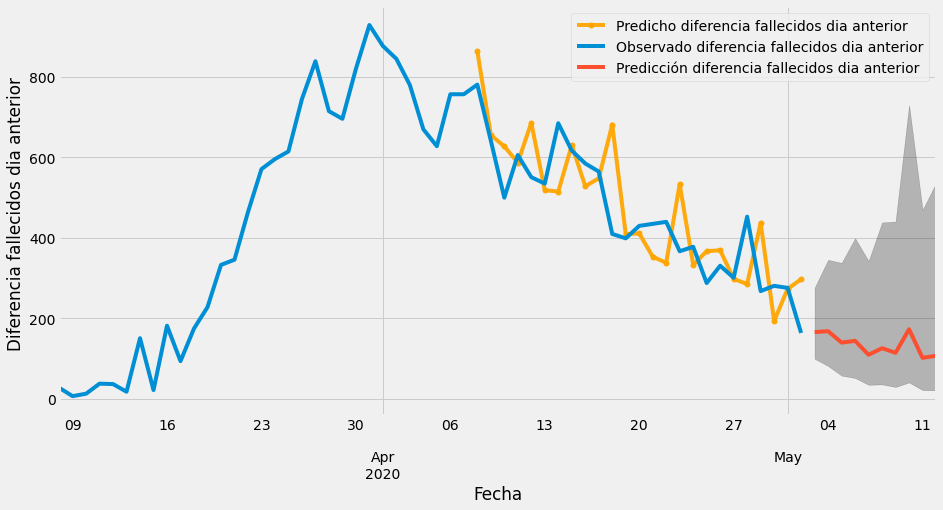

In [46]:
pred_uc_prev = results.get_prediction(start=pd.to_datetime('2020-04-08 00:00:00'))
pred_uc_prev = math.e**pred_uc_prev.predicted_mean

print(pred_uc_prev)

ax = pred_uc_prev.plot( alpha=.95, figsize=(14, 7),color= "orange",
                       label='Predicho diferencia fallecidos dia anterior',marker='o', markersize=5)

pred_uc = results2.get_forecast(steps=10)


pred_uc = results.get_forecast(steps=10)

pred_ci = pred_uc.conf_int()
pred_ci = math.e**pred_ci
pred_uc = math.e**pred_uc.predicted_mean
ax = data_es["Diferencia fallecidos dia anterior"].plot(label='Observado diferencia fallecidos dia anterior', figsize=(14, 7))
pred_uc.plot(ax=ax, label='Predicción diferencia fallecidos dia anterior')
print(pred_uc)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Diferencia fallecidos dia anterior ')
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\predicción.png')

plt.legend()
plt.show()

In [47]:
from statsmodels.formula.api import ols
data_mad= data_mad[data_mad["fecha_informe"] == data_mad["fecha_informe"].max()]
results = ols('tasa_incidencia_acumulada_total ~ data_mad["Renta Categorical"] ', data=data_mad).fit()
table = sm.stats.anova_lm(results)
table

,df,sum_sq,mean_sq,F,PR(>F)
"data_mad[""Renta Categorical""]",4.0,1.256463e+06,314115.680078,2.986539,0.022659
Residual,96.0,1.009701e+07,105177.161007,NaN,NaN


In [48]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     tasa_incidencia_acumulada_total   R-squared:                       0.111
Model:                                         OLS   Adj. R-squared:                  0.074
Method:                              Least Squares   F-statistic:                     2.987
Date:                             Sun, 03 May 2020   Prob (F-statistic):             0.0227
Time:                                     11:55:10   Log-Likelihood:                -724.70
No. Observations:                              101   AIC:                             1459.
Df Residuals:                                   96   BIC:                             1472.
Df Model:                                        4                                         
Covariance Type:                         nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                            889.6400     78.657     11.310      0.000     733.507    1045.773
data_mad["Renta Categorical"][T.Renta Baja]          151.1331    119.488      1.265      0.209     -86.049     388.315
data_mad["Renta Categorical"][T.Renta Media-Alta]   -168.2447    114.886     -1.464      0.146    -396.291      59.801
data_mad["Renta Categorical"][T.Renta Media-Baja]   -150.0679     99.716     -1.505      0.136    -348.002      47.866
data_mad["Renta Categorical"][T.Renta Media-Media]  -168.2529     99.716     -1.687      0.095    -366.187      29.681
==============================================================================
Omnibus:                        6.076   Durbin-Watson:                   1.611
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                5.536
Skew:                           0.551   Prob(JB):                       0.0628
Kurtosis:                       3.317   Cond. No.                         6.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""